In [140]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation

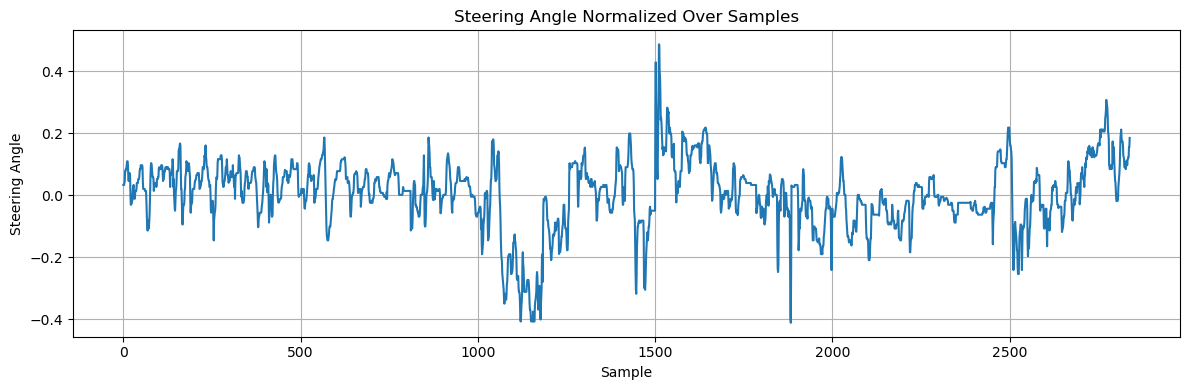

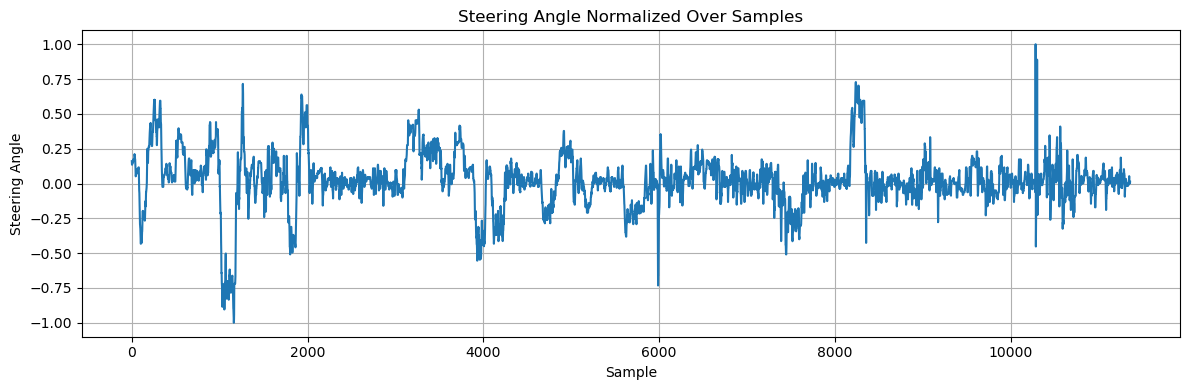

In [141]:
#def normalize_data(arr):
#    arr = arr.astype(np.float32)
#    return (arr - arr.min()) / (arr.max() - arr.min())

def normalize_data(arr):
    arr = arr.astype(np.float32)
    return 2.0 * (arr - arr.min()) / (arr.max() - arr.min()) - 1.0
    
LOG_H5 = r'E:\comma-dataset\log\2016-01-30--11-24-51.h5'
CAM_H5 = r'E:\comma-dataset\camera\2016-01-30--11-24-51.h5'

with h5py.File(LOG_H5, 'r') as logs:
    
    df = pd.DataFrame(
        np.column_stack([
            logs['steering_angle'][:],     
            logs['speed'][:],
            logs['car_accel'][:],
            logs['brake'][:],
            logs['standstill'][:],
            logs['cam1_ptr'][:]
        ]),
        columns=['steering_angle', 'speed', 'accel', 'brake', 'stopped', 'cam_idx']
    )

df = df.iloc[::10]                   
df = df.iloc[2300:16500]             

frame_indices = df['cam_idx'].astype(int).values
labels        = normalize_data(df['steering_angle'].values)

idx_train, idx_val, y_train, y_val = train_test_split(
    frame_indices, labels, test_size=0.20, shuffle=False
)

plt.figure(figsize=(12, 4))
plt.plot(y_val, label='Steering Angle')
plt.xlabel('Sample')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Normalized Over Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_train, label='Steering Angle')
plt.xlabel('Sample')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Normalized Over Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class CommaSequence(Sequence):
    def __init__(self, cam_h5_path, frame_ids, targets,
                 batch_size=64, shuffle=True):
        self.cam_h5_path = cam_h5_path
        self.frame_ids   = np.asarray(frame_ids)
        self.targets     = np.asarray(targets, dtype=np.float32)
        self.batch_size  = batch_size
        self.shuffle     = shuffle

        self.cam_file = h5py.File(cam_h5_path, 'r')
        self.frames_ds = self.cam_file['X']
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.frame_ids) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            p = np.random.permutation(len(self.frame_ids))
            self.frame_ids, self.targets = self.frame_ids[p], self.targets[p]


    # image procesing pipeline to prepare data for model
    def preprocess_lane_features(self, img):
        height, width = img.shape[:2]

        # Step 1: ROI mask
        roi_mask = np.zeros((height, width), dtype=np.uint8)
        polygon = np.array([[
            (0, height),
            (width, height),
            (int(width * 0.7), int(height * 0.5)),
            (int(width * 0.5), int(height * 0.5))
        ]], np.int32)
        cv2.fillPoly(roi_mask, polygon, 255)
        # yellow detection
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        L_lab, A_lab, B_lab = cv2.split(lab)
        B_blur = cv2.blur(B_lab, (10, 10))
        yellow_mask = (B_lab > B_blur + 10)  # brighter yellow than local mean

        # Step 2: Convert to HLS
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        h, l, s = cv2.split(hls)
        
        # Step 3: Local mean filtering
        kernel_size = (10, 10)
        h_blur = cv2.blur(h, kernel_size)
        l_blur = cv2.blur(l, kernel_size)
        s_blur = cv2.blur(s, kernel_size)
        white_mask = (
            (l > l_blur + 5) &
            (s < s_blur)
        )
        color_mask = np.zeros_like(h, dtype=np.uint8)
        color_mask[yellow_mask | white_mask] = 255
        color_mask = cv2.bitwise_and(color_mask, roi_mask)

        # Step 5: Mask + Canny edge detection
        masked = cv2.bitwise_and(img, img, mask=color_mask)
        gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur.astype(np.uint8), 50, 150)

        # Step 6: Hough line detection
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi / 180,
            threshold=50,
            minLineLength=20,
            maxLineGap=20
        )

        # Step 7: Draw filtered lines on darkened background
        overlay = np.ascontiguousarray((img * 0.3).astype(np.uint8))
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                slope = (y2 - y1) / (x2 - x1 + 1e-5)
                length = np.hypot(x2 - x1, y2 - y1)
                # Filter out nearly horizontal lines and very short segments
                if 0.3 < abs(slope) < 2.0 and length > 40:
                    cv2.line(overlay, (x1, y1), (x2, y2), (255, 255, 0), 3)  # bright cyan

        return overlay

    def __getitem__(self, idx):
        slc = slice(idx * self.batch_size, (idx + 1) * self.batch_size)
        ids = self.frame_ids[slc]

        # h5py indexing must be sorted
        sort_idx   = np.argsort(ids)
        sorted_ids = ids[sort_idx]
        batch_imgs = self.frames_ds[sorted_ids]                
        batch_imgs = batch_imgs[np.argsort(sort_idx)]           
        # batch_imgs = np.transpose(batch_imgs, (0, 2, 3, 1)).astype(np.uint8)
      
        # processed_imgs = []
        # for i, img in enumerate(batch_imgs):
        #     # proc = self.preprocess_lane_features(img)
        #     # proc = proc[:, :, ::-1] / 255.0  # BGR → RGB and normalize
        #     # processed_imgs.append(proc.astype(np.float32))
        #     try:
        #         proc = self.preprocess_lane_features(img)
        #         proc = proc[:, :, ::-1] / 255.0  # BGR → RGB and normalize
        #         processed_imgs.append(proc.astype(np.float32))
        #     except Exception as e:
        #         print(f"[ERROR] Preprocessing failed on image {i}: {e}")
        #         # fallback: append raw image
        #         fallback = img[:, :, ::-1] / 255.0
        #         processed_imgs.append(fallback.astype(np.float32))

        batch_imgs = np.transpose(batch_imgs, (0, 2, 3, 1)).astype(np.float32)
        batch_imgs = (batch_imgs / 255.0)


        batch_labels = self.targets[slc]
        return batch_imgs, batch_labels

    def __del__(self):
        try:
            self.cam_file.close()
        except Exception:
            pass

train_gen = CommaSequence(CAM_H5, idx_train, y_train, batch_size=32, shuffle=True)
val_gen   = CommaSequence(CAM_H5, idx_val,   y_val,   batch_size=32, shuffle=False)


In [143]:
def nvidia_model(input_shape=(160, 320, 3)):
    model = Sequential([
        Conv2D(24, (5, 5), strides=(2, 2), activation='elu', input_shape=input_shape),
        Conv2D(36, (5, 5), strides=(2, 2), activation='elu'),
        Conv2D(48, (5, 5), strides=(2, 2), activation='elu'),
        Conv2D(64, (3, 3), activation='elu'),
        Conv2D(64, (3, 3), activation='elu'),
        Flatten(),
        Dense(100, activation='elu'), Dropout(0.25),
        Dense(50,  activation='elu'), Dropout(0.25),
        Dense(10,  activation='elu'), Dropout(0.25),
        Dense(1,   activation='linear')
    ])
    return model

In [144]:
def cnn_model():
    '''Proposed modifications to Nvidia PilotNet model. 

    '''
    model = Sequential()
    model.add(Conv2D(64, 3, data_format='channels_last', kernel_initializer='he_normal',
                     input_shape=(160, 320, 3)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(Conv2D(24, (5, 5), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(Conv2D(36, (5, 5), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(Conv2D(48, (5, 5), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(Dropout(0.6))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.6))

    model.add(Dense(1))

    model.summary()

    return model

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, SpatialDropout2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.regularizers import l2


def opt_nvidia_model_light(input_shape=(160, 320, 3),
                           l2_reg: float = 1e-4,
                           dropout_rate: float = 0.3) -> Sequential:
    """
    Leaner Sequential network for steering-angle prediction.
    • No cropping/normalisation (handled in the generator)
    • Three convolutional stages → GAP → two small dense layers
    """

    model = Sequential()

    # ----- 5×5 conv stem ----------------------------------------------------
    model.add(
        Conv2D(24, (5, 5), strides=(2, 2), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg),
               input_shape=input_shape)
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    model.add(
        Conv2D(36, (5, 5), strides=(2, 2), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg))
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    model.add(
        Conv2D(48, (3, 3), strides=(1, 1), padding="same",
               use_bias=False, kernel_regularizer=l2(l2_reg))
    )
    model.add(BatchNormalization())
    model.add(Activation("elu"))
    model.add(SpatialDropout2D(dropout_rate))

    # ----- global pooling & compact dense head -----------------------------
    model.add(Flatten())

    model.add(Dense(48, activation="elu", kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(16, activation="elu", kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear", name="steering"))

    # print callable, mimicking your original style
    print(model.summary)

    return model

In [146]:
model = opt_nvidia_model_light()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    workers=8,
    use_multiprocessing=False,
    shuffle=False,
    max_queue_size=10     
)

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000001B74A1DA898>>
355/355 [==============================] - 179s 490ms/step - loss: 0.9510 - mae: 0.6729 - val_loss: 0.0939 - val_mae: 0.1671


89/89 [==============================] - 52s 587ms/step


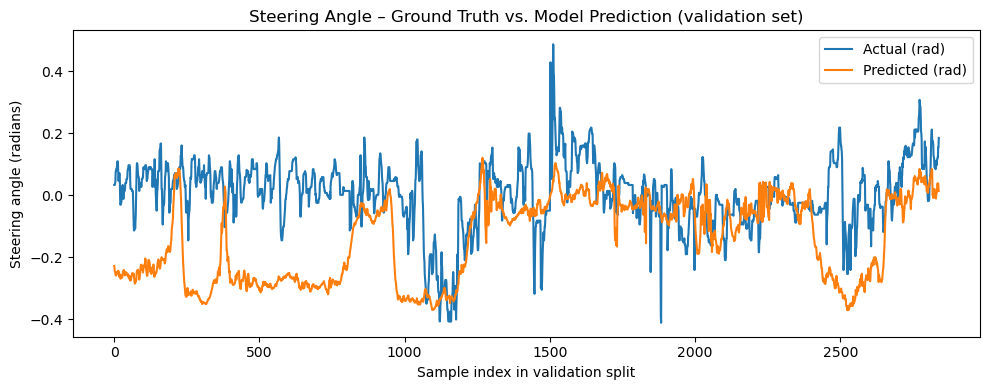

In [ ]:
y_pred = model.predict(val_gen).squeeze()
#assert y_pred.shape == y_val.shape

plt.figure(figsize=(10, 4))
plt.plot(y_val,  label='Actual (rad)')
plt.plot(y_pred, label='Predicted (rad)')
plt.title('Steering Angle – Ground Truth vs. Model Prediction (validation set)')
plt.xlabel('Sample index in validation split')
plt.ylabel('Steering angle (radians)')
plt.legend()
plt.tight_layout()
plt.show()

In [148]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_pred, y_val)
print(mse)

0.044221316
